In [35]:
# jupyter notebook
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

import matplotlib.pyplot as plt
import torchvision

In [36]:
# jupyter notebook
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [37]:
# jupyter notebook
class Args(argparse.Namespace):
    lr=0.0001
    lr_backbone=1e-05
    batch_size=2
    weight_decay=0.0001
    epochs=300
    lr_drop=200
    clip_max_norm=0.1
    frozen_weights=None
    backbone='resnet50'
    dilation=False
    position_embedding='sine'
    enc_layers=6
    dec_layers=6
    dim_feedforward=2048
    hidden_dim=256
    dropout=0.1
    nheads=8
    num_queries=100
    pre_norm=False
    masks=False
    aux_loss=True
    set_cost_class=1
    set_cost_bbox=5
    set_cost_giou=2
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    dataset_file='coco'
    # coco_path=r'/mnt/c/MyData/2024/COCO/datasets'
    coco_path=r'C:\MyData\2024\COCO\datasets'
    coco_panoptic_path=None
    remove_difficult=False
    output_dir=''
    device='cuda'
    seed=42
    resume=''
    start_epoch=0
    eval=False
    num_workers=2
    world_size=1
    dist_url='env://'
    distributed=False

args = Args()

In [38]:
# jupyter notebook
# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [39]:
# jupyter notebook
dataset_train = build_dataset(image_set='train', args=args)

loading annotations into memory...
Done (t=12.87s)
creating index...
index created!


In [40]:
# jupyter notebook
print(len(dataset_train[0]))
print(dataset_train[0][0].shape)
print(dataset_train[1][0].shape)
dataset_train[0][1]

2
torch.Size([3, 512, 682])
torch.Size([3, 480, 646])


{'boxes': tensor([[0.5205, 0.6888, 0.9556, 0.5955],
         [0.2635, 0.2472, 0.4989, 0.4764],
         [0.3629, 0.7329, 0.4941, 0.5106],
         [0.6606, 0.4189, 0.6789, 0.7815],
         [0.3532, 0.1326, 0.1180, 0.0969],
         [0.2269, 0.1298, 0.0907, 0.0972],
         [0.3317, 0.2269, 0.1313, 0.1469],
         [0.3571, 0.0792, 0.1481, 0.1481]]),
 'labels': tensor([51, 51, 56, 51, 55, 55, 55, 55]),
 'image_id': tensor([9]),
 'area': tensor([282171.7812, 104435.5469, 116523.6641,  57095.6250,   5263.0371,
           3898.9131,   8482.9902,   6992.8281]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([736, 981])}

In [41]:
dataset_train[0][1]

{'boxes': tensor([[0.5000, 0.6808, 1.0000, 0.6346],
         [0.7779, 0.2320, 0.4442, 0.4640],
         [0.7073, 0.7278, 0.5855, 0.5441],
         [0.4174, 0.4048, 0.8347, 0.8096],
         [0.7881, 0.0880, 0.1717, 0.1033],
         [0.9529, 0.0850, 0.0941, 0.1036],
         [0.8193, 0.1885, 0.1910, 0.1565],
         [0.7823, 0.0550, 0.2154, 0.1100]]),
 'labels': tensor([51, 51, 56, 51, 55, 55, 55, 55]),
 'image_id': tensor([9]),
 'area': tensor([351720.2812, 114242.3984, 176553.1562, 374516.9375,   9830.8096,
           5405.9229,  16567.4375,  13133.4287]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([753, 736])}

In [42]:
example = dataset_train[0]
example

(tensor([[[ 0.1254,  0.1597,  0.1768,  ..., -2.1008, -2.1008, -2.0837],
          [ 0.1254,  0.1768,  0.1939,  ..., -2.0837, -2.0665, -2.0494],
          [ 0.1254,  0.1768,  0.2111,  ..., -2.1008, -2.0837, -2.0665],
          ...,
          [-2.0152, -2.0323, -2.0152,  ..., -2.0152, -2.0323, -2.0494],
          [-2.0665, -2.0494, -1.9980,  ..., -2.0152, -2.0323, -2.0323],
          [-2.0837, -2.0837, -2.0837,  ..., -2.0152, -2.0323, -2.0494]],
 
         [[ 0.9055,  0.9405,  0.9580,  ..., -1.6331, -1.6331, -1.6155],
          [ 0.9055,  0.9580,  0.9755,  ..., -1.6331, -1.6155, -1.5980],
          [ 0.9055,  0.9580,  0.9930,  ..., -1.6506, -1.6506, -1.6331],
          ...,
          [-1.9832, -1.9482, -1.9132,  ..., -2.0182, -2.0357, -2.0357],
          [-1.9832, -1.9832, -1.9657,  ..., -2.0182, -2.0357, -2.0357],
          [-1.9482, -1.9657, -1.9832,  ..., -2.0182, -2.0357, -2.0357]],
 
         [[ 1.5942,  1.6117,  1.6291,  ...,  0.0953,  0.0953,  0.0953],
          [ 1.5768,  1.6291,

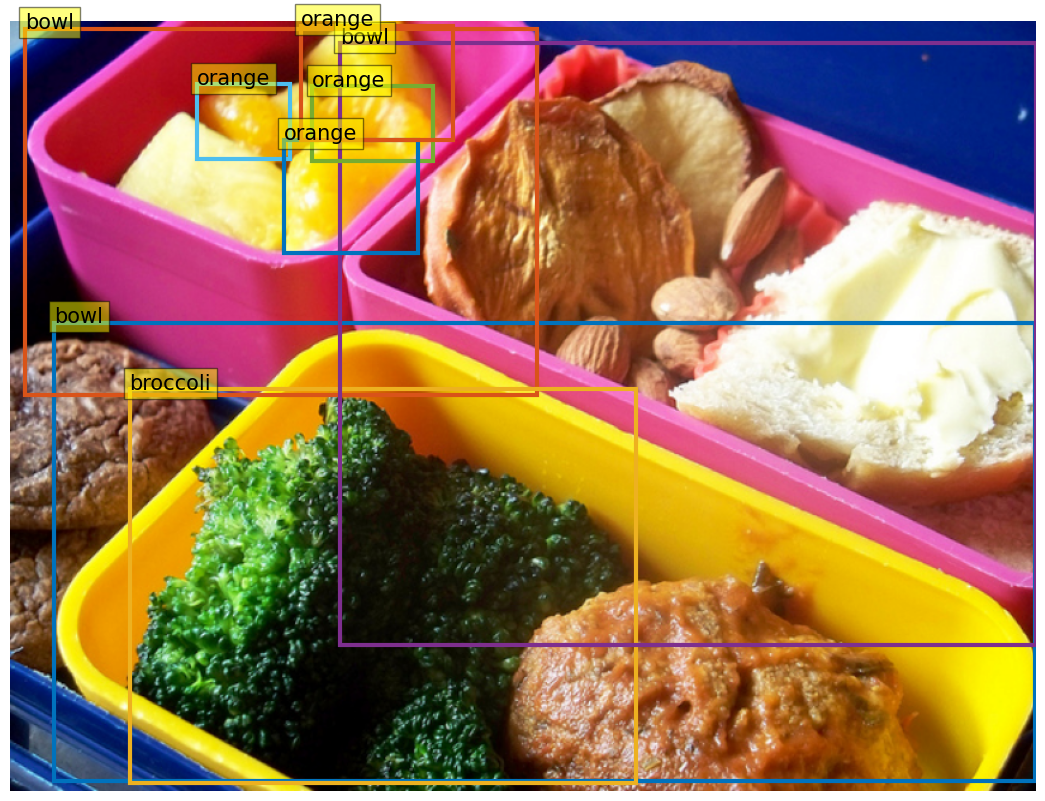

In [43]:
plot_results(example[0], example[1]['labels'], example[1]['boxes'])

In [44]:
device = 'cuda'
model, criterion, postprocessors = build_model(args)
model.to(device)
model

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [45]:
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler, BatchSampler
sampler = RandomSampler(dataset_train)
batch_sampler = BatchSampler(sampler, args.batch_size, drop_last=True)
data_loader = DataLoader(dataset_train, batch_sampler=batch_sampler, collate_fn=utils.collate_fn, num_workers=args.num_workers)

for X, y in data_loader:
    break


In [46]:
type(X)

util.misc.NestedTensor

In [ ]:
preds = model(X.to(device))
print(preds.keys())

In [48]:
preds['pred_logits'].shape, preds['pred_boxes'].shape

(torch.Size([2, 100, 92]), torch.Size([2, 100, 4]))

In [49]:
import torchvision

m = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

new_m = torchvision.models._utils.IntermediateLayerGetter(m, {'layer1': 'feat1', 'layer2': 'feat2'})
new_m

IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU

In [50]:
import torch
out = new_m(torch.rand(1, 3, 224, 224))
type(out)

collections.OrderedDict

In [51]:
out.keys()

odict_keys(['feat1', 'feat2'])